## Carga de librerías necesarias

Importamos bibliotecas para análisis de datos (`pandas`, `numpy`), visualización (`matplotlib`, `seaborn`), modelado (`sklearn`, `xgboost`) y warnings para silenciar mensajes no deseados

In [ ]:
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
import joblib
from pathlib import Path
from pycaret.regression import *
import sys, os
sys.path.append(os.path.abspath(".."))
from marketvalue.config import CT_ENCODER_PATH, PCA_ENCODER_DIR, MLB_DIR, PCA_GROUPS_PATH
from marketvalue.config import (
    STATS_FIELD_PLAYERS_PATH,
    TRANSFERS_FIELD_PLAYERS_PATH,
    STATS_NEWS_PATH,
    SEASON,
    PRODUCTION_DATA_PATH,
    TRAINING_DATA_PATH,
    MODEL_PATH,
)

import pandas as pd
from marketvalue.processing import prepare_data
from marketvalue.feature_engineering import build_dataset
from marketvalue.feature_engineering import train_pycaret_model

## Carga del dataset

Se carga el archivo CSV que contiene la información de jugadores. Este dataset contiene variables numéricas y categóricas, incluyendo características físicas, habilidades y posición en el campo.

In [ ]:
# Cargar dataset de transferencias
stats_field_players = pd.read_csv(STATS_FIELD_PLAYERS_PATH)
transfers_field_players = pd.read_csv(TRANSFERS_FIELD_PLAYERS_PATH)
news = pd.read_csv(STATS_NEWS_PATH)

data_training, data_production = prepare_data(SEASON, stats_field_players, transfers_field_players, news)

In [210]:
df_transferencias = data_training

## Ingeniería de características y selección de variables

- Se seleccionan columnas relevantes para la predicción del valor de mercado.

In [232]:
cols_shooting = [
    "shooting_Gls", "shooting_SoT%", "shooting_Sh/90", "shooting_SoT/90", 
    "shooting_G/Sh", "shooting_G/SoT", "shooting_Dist", "shooting_xG", "shooting_npxG/Sh"
]

cols_passing = [
    "passing_Cmp", "passing_Att", "passing_Cmp%", "passing_Ast", "passing_xAG", 
    "passing_xA", "passing_KP", "passing_PPA", "passing_PrgP"
]

cols_possession = [
    "possession_Touches", "possession_Carries", "possession_PrgC", "possession_PrgR", 
    "possession_Rec", "possession_PrgDist", "possession_Mis", "possession_Dis", 
    "possession_Att", "possession_Succ", "possession_Succ%", "possession_Tkld"
]

cols_playingtime = [
    "playingtime_MP", "playingtime_Min", "playingtime_Starts", "playingtime_Subs", 
    "playingtime_PPM", "playingtime_+/-90", "playingtime_onxG", "playingtime_onxGA", 
    "playingtime_xG+/-", "playingtime_xG+/-90"
]

cols_misc = [
    "misc_Age", "misc_CrdY", "misc_CrdR", "misc_Fls", "misc_Fld", "misc_Off", 
    "misc_Recov", "misc_PKwon", "misc_PKcon", "misc_OG", "misc_Nation", 
    "misc_Comp", "misc_Pos", "misc_Int"
]

cols_stats = [
    "stats_G-PK", "stats_npxG+xAG", "stats_Gls.1", "stats_Ast.1", 
    "stats_xG.1", "stats_xAG.1"
]

columns_utiles = cols_misc + cols_passing + cols_playingtime + cols_possession + cols_shooting + cols_stats

def remove_unnecessary_cols(df, columns_utiles, train):
    print("\n🧹 Removiendo columnas innecesarias...")

    columnas_encontradas = [col for col in columns_utiles if col in df.columns]
    columnas_faltantes = [col for col in columns_utiles if col not in df.columns]

    print(f"\n✅ Columnas encontradas ({len(columnas_encontradas)}):")
    print(columnas_encontradas)

    print(f"\n⚠️ Columnas faltantes ({len(columnas_faltantes)}):")
    print(columnas_faltantes)

    if train:
        print("\n🏋️ Modo entrenamiento: incluyendo columna 'fee'")
        columnas_encontradas += ["fee"]

    df_filtrado = df[columnas_encontradas]

    print(f"\n📊 Columnas finales en el DataFrame filtrado ({len(df_filtrado.columns)}):")
    print(df_filtrado.columns.tolist())
    print(f"→ Forma final del DataFrame: {df_filtrado.shape}")

    return df_filtrado

df = remove_unnecessary_cols(df_transferencias, columns_utiles, True)
print(df_transferencias.columns.tolist())
print(df.columns.tolist())



🧹 Removiendo columnas innecesarias...

✅ Columnas encontradas (59):
['misc_Age', 'misc_CrdY', 'misc_CrdR', 'misc_Fls', 'misc_Fld', 'misc_Off', 'misc_Recov', 'misc_PKwon', 'misc_PKcon', 'misc_OG', 'misc_Nation', 'misc_Comp', 'misc_Pos', 'misc_Int', 'passing_Cmp', 'passing_Cmp%', 'passing_Ast', 'passing_xAG', 'passing_xA', 'passing_KP', 'passing_PPA', 'passing_PrgP', 'playingtime_MP', 'playingtime_Min', 'playingtime_Starts', 'playingtime_Subs', 'playingtime_PPM', 'playingtime_+/-90', 'playingtime_onxG', 'playingtime_onxGA', 'playingtime_xG+/-', 'playingtime_xG+/-90', 'possession_Touches', 'possession_Carries', 'possession_PrgC', 'possession_PrgR', 'possession_Rec', 'possession_PrgDist', 'possession_Mis', 'possession_Dis', 'possession_Att', 'possession_Succ', 'possession_Succ%', 'possession_Tkld', 'shooting_Gls', 'shooting_SoT%', 'shooting_Sh/90', 'shooting_SoT/90', 'shooting_G/Sh', 'shooting_G/SoT', 'shooting_Dist', 'shooting_xG', 'shooting_npxG/Sh', 'stats_G-PK', 'stats_npxG+xAG', 'sta

# 🧹 Limpieza de Datos: Eliminación de Filas con Valores Nulos en Columnas Numéricas

Este bloque realiza lo siguiente:

- Selecciona todas las columnas numéricas del DataFrame.
- Elimina las filas que tengan valores nulos (`NaN`) en **cualquiera** de esas columnas numéricas.
- Imprime la cantidad de valores nulos restantes en cada columna para verificar que la limpieza fue efectiva.


In [233]:
num_cols = df.select_dtypes(include='number').columns.tolist()
df = df.dropna(subset=num_cols)
print(df.isnull().sum())

misc_Age               0
misc_CrdY              0
misc_CrdR              0
misc_Fls               0
misc_Fld               0
misc_Off               0
misc_Recov             0
misc_PKwon             0
misc_PKcon             0
misc_OG                0
misc_Nation            0
misc_Comp              0
misc_Pos               0
misc_Int               0
passing_Cmp            0
passing_Cmp%           0
passing_Ast            0
passing_xAG            0
passing_xA             0
passing_KP             0
passing_PPA            0
passing_PrgP           0
playingtime_MP         0
playingtime_Min        0
playingtime_Starts     0
playingtime_Subs       0
playingtime_PPM        0
playingtime_+/-90      0
playingtime_onxG       0
playingtime_onxGA      0
playingtime_xG+/-      0
playingtime_xG+/-90    0
possession_Touches     0
possession_Carries     0
possession_PrgC        0
possession_PrgR        0
possession_Rec         0
possession_PrgDist     0
possession_Mis         0
possession_Dis         0


# 🧩 Aplicación de PCA para Reducir la Dimensionalidad en Grupos de Columnas Altamente Correlacionadas

Este bloque de código implementa un proceso para identificar grupos de columnas numéricas que están altamente correlacionadas en un DataFrame y aplicarles **PCA (Análisis de Componentes Principales)** para reducir su dimensionalidad a una sola variable representativa.

In [234]:
def apply_pca_to_group(df, columns, group_name, train=True):
    print(f"\n→ Aplicando PCA al grupo: {columns} con nombre: {group_name}")
    scaler_path = PCA_ENCODER_DIR / f"{group_name}_scaler.joblib"
    pca_path = PCA_ENCODER_DIR / f"{group_name}_pca.joblib"

    if train:
        print(f"  ↪️ Modo entrenamiento. Guardando scaler en: {scaler_path.name} y PCA en: {pca_path.name}")
        scaler = StandardScaler()
        scaled = scaler.fit_transform(df[columns])
        pca = PCA(n_components=1)
        pca_result = pca.fit_transform(scaled)

        #joblib.dump(scaler, scaler_path)
        #joblib.dump(pca, pca_path)
    else:
        if not scaler_path.exists() or not pca_path.exists():
            print(f"  ⚠️ Saltando PCA para {group_name}, modelos no encontrados")
            return df
        print(f"  ↩️ Modo inferencia. Cargando scaler y PCA desde disco")
        scaler = joblib.load(scaler_path)
        pca = joblib.load(pca_path)
        scaled = scaler.transform(df[columns])
        pca_result = pca.transform(scaled)

    new_col_name = f"pca_{columns[0]}"
    print(f"  ✅ Nueva columna agregada: {new_col_name}")
    df[new_col_name] = pca_result[:, 0]
    print(f"  ❌ Eliminando columnas originales: {columns}")
    df.drop(columns=columns, inplace=True)
    return df


def get_correlation_groups(df, threshold=0.95, train=True):
    print("\n📊 Buscando columnas numéricas...")
    numeric_df = df.select_dtypes(include='number').copy()
    print(f"→ Columnas numéricas encontradas ({len(numeric_df.columns)}): {numeric_df.columns.tolist()}")

    if train:
        print(f"\n🔍 Modo entrenamiento activado. Calculando correlaciones con umbral: {threshold}")
        corr = numeric_df.corr().abs()
        G = nx.Graph()
        G.add_nodes_from(corr.columns)

        for i in range(len(corr.columns)):
            for j in range(i + 1, len(corr.columns)):
                if corr.iloc[i, j] > threshold:
                    G.add_edge(corr.columns[i], corr.columns[j])

        groups = [list(g) for g in nx.connected_components(G) if len(g) >= 2]
        print(f"→ Se encontraron {len(groups)} grupos de columnas altamente correlacionadas.")
        for idx, group in enumerate(groups, 1):
            print(f"  - Grupo {idx}: {group}")
        joblib.dump(groups, PCA_GROUPS_PATH)
        print(f"✅ Grupos guardados en: {PCA_GROUPS_PATH}")
    else:
        if not PCA_GROUPS_PATH.exists():
            print("❌ No se encontró el archivo de grupos PCA")
            return df
        groups = joblib.load(PCA_GROUPS_PATH)
        print(f"📂 Grupos cargados desde: {PCA_GROUPS_PATH}")

    print("\n⚙️ Aplicando PCA a los grupos correlacionados...")
    for group in groups:
        group = [col for col in group if col in df.columns]
        if len(group) < 2:
            print(f"  ⏩ Grupo con menos de 2 columnas presentes, saltado: {group}")
            continue
        group_name = "_".join(group)
        df = apply_pca_to_group(df, group, group_name, train=train)

    print("\n✅ PCA aplicado exitosamente. Columnas actuales del DataFrame:")
    print(df.columns.tolist())
    return df

df = get_correlation_groups(df, threshold=0.85, train=True)



📊 Buscando columnas numéricas...
→ Columnas numéricas encontradas (55): ['misc_Age', 'misc_CrdY', 'misc_CrdR', 'misc_Fls', 'misc_Fld', 'misc_Off', 'misc_Recov', 'misc_PKwon', 'misc_PKcon', 'misc_OG', 'misc_Int', 'passing_Cmp', 'passing_Cmp%', 'passing_Ast', 'passing_xAG', 'passing_xA', 'passing_KP', 'passing_PPA', 'passing_PrgP', 'playingtime_MP', 'playingtime_Starts', 'playingtime_Subs', 'playingtime_PPM', 'playingtime_+/-90', 'playingtime_onxG', 'playingtime_onxGA', 'playingtime_xG+/-', 'playingtime_xG+/-90', 'possession_Touches', 'possession_Carries', 'possession_PrgC', 'possession_PrgR', 'possession_Rec', 'possession_PrgDist', 'possession_Mis', 'possession_Dis', 'possession_Att', 'possession_Succ', 'possession_Succ%', 'possession_Tkld', 'shooting_Gls', 'shooting_SoT%', 'shooting_Sh/90', 'shooting_SoT/90', 'shooting_G/Sh', 'shooting_G/SoT', 'shooting_Dist', 'shooting_xG', 'shooting_npxG/Sh', 'stats_G-PK', 'stats_npxG+xAG', 'stats_Gls.1', 'stats_Ast.1', 'stats_xG.1', 'stats_xAG.1']


# 🔤 Codificación de Variables Categóricas y Multilabel

Este bloque transforma las columnas categóricas y multilabel del DataFrame en variables numéricas binarias (one-hot encoding), necesarias para modelos de machine learning que no manejan variables categóricas directamente.


In [235]:
def encode_categorical_columns(
    df,
    multilabel_cols,
    categorical_cols,
    multilabel_sep=",",
    training=True,
    mlb_dir: Path = None,
    ct_path: Path = None
):
    df = df.copy()

    print("\n🔍 Codificando columnas categóricas y multilabel...")
    print(f"→ Columnas multilabel: {multilabel_cols}")
    print(f"→ Columnas categóricas simples: {categorical_cols}")

    multilabel_dfs = []
    mlb_dict = {}

    # Multilabel encode
    for col in multilabel_cols:
        print(f"\n➡️ Procesando multilabel: '{col}'")
        multilabel_data = df[col].fillna("").apply(lambda x: [v.strip() for v in x.split(multilabel_sep) if v.strip()])
        if training:
            print(f"  🏗️ Entrenando MultiLabelBinarizer para '{col}'")
            mlb = MultiLabelBinarizer()
            onehot = mlb.fit_transform(multilabel_data)
            print(f"  ✅ Clases detectadas: {mlb.classes_.tolist()}")
            if mlb_dir is not None:
                path = mlb_dir / f"mlb_{col}.joblib"
                joblib.dump(mlb, path)
                print(f"  💾 Guardado en: {path}")
        else:
            if mlb_dir is not None:
                mlb = joblib.load(mlb_dir / f"mlb_{col}.joblib")
                print(f"  📂 Cargando MLBin desde: {mlb_dir / f'mlb_{col}.joblib'}")
            else:
                raise ValueError("mlb_dir es necesario en modo producción")
            onehot = mlb.transform(multilabel_data)
        onehot_df = pd.DataFrame(onehot, columns=[f"{col}_{cls}" for cls in mlb.classes_], index=df.index)
        print(f"  🧾 Nuevas columnas: {onehot_df.columns.tolist()}")
        multilabel_dfs.append(onehot_df)
        mlb_dict[col] = mlb

    # One hot encode simple
    if categorical_cols:
        print(f"\n➡️ Procesando columnas categóricas simples: {categorical_cols}")
        if training:
            print("  🏗️ Entrenando OneHotEncoder...")
            ct = ColumnTransformer(
                transformers=[
                    ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_cols)
                ],
                remainder="drop"
            )
            onehot_array = ct.fit_transform(df[categorical_cols])
            if ct_path is not None:
                joblib.dump(ct, ct_path)
                print(f"  💾 Codificador guardado en: {ct_path}")
        else:
            if ct_path is not None:
                ct = joblib.load(ct_path)
                print(f"  📂 Cargando codificador desde: {ct_path}")
            else:
                raise ValueError("ct_path es necesario en modo producción")
            onehot_array = ct.transform(df[categorical_cols])

        onehot_columns = ct.named_transformers_["onehot"].get_feature_names_out(categorical_cols)
        print(f"  🧾 Nuevas columnas generadas: {onehot_columns.tolist()}")
        onehot_df = pd.DataFrame(onehot_array, columns=onehot_columns, index=df.index)
    else:
        print("  ⚠️ No se especificaron columnas categóricas simples.")
        onehot_df = pd.DataFrame(index=df.index)

    # Eliminar columnas originales codificadas
    cols_to_drop = multilabel_cols + categorical_cols
    print(f"\n🗑️ Eliminando columnas originales: {cols_to_drop}")
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

    # Concatenar resultados
    dfs_to_concat = [df] + multilabel_dfs + [onehot_df]
    df_final = pd.concat(dfs_to_concat, axis=1)

    print("\n✅ Codificación completa. Columnas finales del DataFrame:")
    print(df_final.columns.tolist())
    print(f"→ Forma final del DataFrame: {df_final.shape}")

    return df_final
df_encoded = encode_categorical_columns(
        df,
        multilabel_cols=["misc_Pos"],
        categorical_cols=["misc_Comp", "misc_Nation"],
        training=True,
        mlb_dir=MLB_DIR,
        ct_path=CT_ENCODER_PATH
)

print(df_encoded)
print(df_encoded.columns.tolist())



🔍 Codificando columnas categóricas y multilabel...
→ Columnas multilabel: ['misc_Pos']
→ Columnas categóricas simples: ['misc_Comp', 'misc_Nation']

➡️ Procesando multilabel: 'misc_Pos'
  🏗️ Entrenando MultiLabelBinarizer para 'misc_Pos'
  ✅ Clases detectadas: ['DF', 'FW', 'GK', 'MF']
  💾 Guardado en: C:\Users\theoj\Market-Value-Predictor\encoders\mlb\mlb_misc_Pos.joblib
  🧾 Nuevas columnas: ['misc_Pos_DF', 'misc_Pos_FW', 'misc_Pos_GK', 'misc_Pos_MF']

➡️ Procesando columnas categóricas simples: ['misc_Comp', 'misc_Nation']
  🏗️ Entrenando OneHotEncoder...
  💾 Codificador guardado en: C:\Users\theoj\Market-Value-Predictor\encoders\ct_encoder.joblib
  🧾 Nuevas columnas generadas: ['misc_Comp_Belgian Pro League', 'misc_Comp_Eredivise', 'misc_Comp_Primeira Liga Portugal', 'misc_Comp_de Bundesliga', 'misc_Comp_eng Premier League', 'misc_Comp_es La Liga', 'misc_Comp_fr Ligue 1', 'misc_Comp_it Serie A', 'misc_Nation_0', 'misc_Nation_al ALB', 'misc_Nation_am ARM', 'misc_Nation_ao ANG', 'misc

# ⚙️ Configuración y Selección de Modelos con PyCaret (Regresión)

Este bloque utiliza PyCaret para preparar los datos, comparar modelos y seleccionar el mejor basado en la métrica **R²**.


In [236]:
Y = df_encoded["fee"]
    
num_cols = df_encoded.select_dtypes(include = 'number').columns.tolist()
X = df_encoded[num_cols]
X = X.dropna(subset = num_cols)

X["fee"] = Y

In [237]:

setup(
        data=X,
        target='fee',
        session_id=123,
        normalize=True,
        fold=5,
        fold_strategy='kfold'
    )

best_model = compare_models(sort='R2')
final_model = finalize_model(best_model)

,Description,Value
0,Session id,123
1,Target,fee
2,Target type,Regression
3,Original data shape,"(2467, 156)"
4,Transformed data shape,"(2467, 156)"
5,Transformed train set shape,"(1726, 156)"
6,Transformed test set shape,"(741, 156)"
7,Numeric features,155
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,5823511.4744,97160665575995.5312,9817896.8461,0.5039,0.0000,2.6855,2.3020
et,Extra Trees Regressor,5943398.5927,105186825756653.2188,10239037.4357,0.4558,0.0000,2.9853,0.2620
gbr,Gradient Boosting Regressor,6210655.5070,106681214014389.9062,10294074.1215,0.4534,0.0000,3.0158,0.1880
xgboost,Extreme Gradient Boosting,6179658.9279,111456041715162.8750,10502309.1374,0.4338,0.0000,2.7145,0.1320
rf,Random Forest Regressor,6396096.4858,114167727146407.7188,10651984.9415,0.4142,0.0000,3.4709,0.4040
ridge,Ridge Regression,7201713.6517,116905700332131.5312,10786796.8154,0.3968,0.0000,5.0613,0.6200
lasso,Lasso Regression,7204457.3599,116921981399274.3125,10787749.7849,0.3967,0.0000,5.0634,0.7780
llar,Lasso Least Angle Regression,7206122.8284,116925746695123.2969,10787955.9859,0.3967,0.0000,5.0634,0.0300
omp,Orthogonal Matching Pursuit,6985078.5291,118051233205295.9531,10825622.8669,0.3952,0.0000,4.5655,0.0240
en,Elastic Net,6881892.8582,121249961042584.8281,10963874.7822,0.3811,0.0000,4.0405,0.0340


# 📊 Pipeline Completo: Entrenamiento del Mejor Modelo con búsqueda aleatoria de hiperparámetros

Este bloque abarca los pasos típicos para preparar datos, entrenar un modelo con búsqueda aleatoria de hiperparámetros y evaluar su desempeño.



---

## 1. División de datos en entrenamiento y validación

Utilizamos `train_test_split` de scikit-learn para separar el dataset en conjuntos de entrenamiento y validación, garantizando que el modelo se entrene con datos y se evalúe con datos no vistos.

In [238]:
X = X.drop('fee', axis=1)

In [239]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.1, random_state=13)
X_test, X_validation, y_test, y_validation = train_test_split(X_temp, y_temp, test_size=0.5, random_state=13)

In [240]:
X_train

,misc_Age,misc_CrdY,misc_CrdR,misc_Fls,misc_Fld,misc_Off,misc_PKwon,misc_PKcon,misc_OG,misc_Int,...,misc_Nation_ua UKR,misc_Nation_us USA,misc_Nation_uy URU,misc_Nation_uz UZB,misc_Nation_ve VEN,misc_Nation_wls WAL,misc_Nation_xk KVX,misc_Nation_za RSA,misc_Nation_zm ZAM,misc_Nation_zw ZIM
2404,20,2,0,9.0,6.0,0.0,0.0,0.0,0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,30,2,0,75.0,36.0,7.0,2.0,1.0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2515,22,0,0,0.0,2.0,1.0,0.0,0.0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1155,26,2,0,27.0,13.0,33.0,0.0,0.0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
832,24,0,0,0.0,2.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,23,1,0,3.0,3.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
937,22,0,0,1.0,0.0,0.0,0.0,0.0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,29,3,0,31.0,38.0,2.0,0.0,1.0,0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2463,18,3,0,38.0,51.0,2.0,1.0,0.0,0,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [241]:
X_test

,misc_Age,misc_CrdY,misc_CrdR,misc_Fls,misc_Fld,misc_Off,misc_PKwon,misc_PKcon,misc_OG,misc_Int,...,misc_Nation_ua UKR,misc_Nation_us USA,misc_Nation_uy URU,misc_Nation_uz UZB,misc_Nation_ve VEN,misc_Nation_wls WAL,misc_Nation_xk KVX,misc_Nation_za RSA,misc_Nation_zm ZAM,misc_Nation_zw ZIM
2207,21,1,0,8.0,2.0,0.0,0.0,0.0,0,22.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
879,28,0,0,0.0,5.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2409,21,3,1,38.0,37.0,1.0,0.0,0.0,0,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2758,19,0,0,1.0,1.0,0.0,0.0,0.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1495,25,3,0,10.0,14.0,2.0,0.0,0.0,0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,26,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2050,20,1,0,1.0,2.0,0.0,0.0,0.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,26,0,0,2.0,1.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
171,29,2,0,7.0,9.0,2.0,0.0,1.0,0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [242]:
X_validation

,misc_Age,misc_CrdY,misc_CrdR,misc_Fls,misc_Fld,misc_Off,misc_PKwon,misc_PKcon,misc_OG,misc_Int,...,misc_Nation_ua UKR,misc_Nation_us USA,misc_Nation_uy URU,misc_Nation_uz UZB,misc_Nation_ve VEN,misc_Nation_wls WAL,misc_Nation_xk KVX,misc_Nation_za RSA,misc_Nation_zm ZAM,misc_Nation_zw ZIM
1124,25,3,0,10.0,11.0,0.0,0.0,0.0,0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1211,22,2,0,21.0,9.0,0.0,0.0,0.0,1,53.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,32,1,0,0.0,1.0,0.0,0.0,0.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
866,23,3,1,24.0,17.0,18.0,1.0,0.0,0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
637,28,0,0,0.0,1.0,0.0,0.0,0.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,20,1,0,2.0,1.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1541,22,3,0,8.0,12.0,0.0,0.0,0.0,0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602,24,1,0,13.0,4.0,0.0,0.0,0.0,0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1918,21,8,1,37.0,11.0,0.0,0.0,1.0,0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [243]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
import numpy as np

# Definir el modelo CatBoost 
catboost_reg = CatBoostRegressor(
    verbose=100,              #
    random_state=13,
    loss_function='RMSE'   
)

# Definir espacio de hiperparámetros
parametros = {
    'learning_rate': uniform(0.03, 0.15),   # rango ajustado
    'depth': randint(4, 8),                  # rango más conservador
    'l2_leaf_reg': uniform(1, 10),
    'iterations': randint(200, 500),         # más iteraciones
    'subsample': uniform(0.7, 0.3),
    'min_data_in_leaf': randint(10, 30)      # evitar hojas muy pequeñas
}

cv = KFold(n_splits=5, shuffle=True, random_state=13)

# RandomizedSearchCV
rs = RandomizedSearchCV(
    estimator=catboost_reg,
    param_distributions=parametros,
    n_iter=45,
    scoring='r2',
    cv=cv,
    random_state=13,
    verbose=1
)

# Entrenar el modelo
rs.fit(X_train, y_train)

# Mejor modelo
best_model = rs.best_estimator_

# Predicción
y_pred = best_model.predict(X_validation)
y_pred = np.maximum(y_pred, 0)

# Métricas
r2_train = r2_score(y_validation, y_pred)
mse_test = mean_squared_error(y_validation, y_pred)
mae_test = mean_absolute_error(y_validation, y_pred)

# Resultados
print(f"Train R²: {r2_score(y_train, best_model.predict(X_train)):.4f}")
print(f"R² (Validación Cruzada): {r2_train:.4f}")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"Mejores hiperparámetros: {rs.best_params_}")


Fitting 5 folds for each of 45 candidates, totalling 225 fits
0:	learn: 13448236.4709003	total: 32.8ms	remaining: 12.3s
100:	learn: 5932608.1157645	total: 248ms	remaining: 675ms
200:	learn: 4084782.3675174	total: 472ms	remaining: 411ms
300:	learn: 2917713.0866600	total: 668ms	remaining: 167ms
375:	learn: 2390226.5953128	total: 861ms	remaining: 0us
0:	learn: 13618641.8030747	total: 28.2ms	remaining: 10.6s
100:	learn: 6131281.6130405	total: 283ms	remaining: 770ms
200:	learn: 4161304.1915896	total: 511ms	remaining: 445ms
300:	learn: 3071369.0292084	total: 740ms	remaining: 184ms
375:	learn: 2575521.7954013	total: 895ms	remaining: 0us
0:	learn: 13219031.9929761	total: 6.98ms	remaining: 2.62s
100:	learn: 6046270.7719838	total: 211ms	remaining: 575ms
200:	learn: 4131473.2341180	total: 424ms	remaining: 369ms
300:	learn: 3022194.2649680	total: 710ms	remaining: 177ms
375:	learn: 2481050.1039303	total: 865ms	remaining: 0us
0:	learn: 13139698.3828084	total: 11ms	remaining: 4.11s
100:	learn: 564888

In [244]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

y_pred = best_model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

# Calcular métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir resultados
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")



Mean Squared Error (MSE): 107934083915482.6250
Mean Absolute Error (MAE): 5712568.9610
R² Score: 0.5929


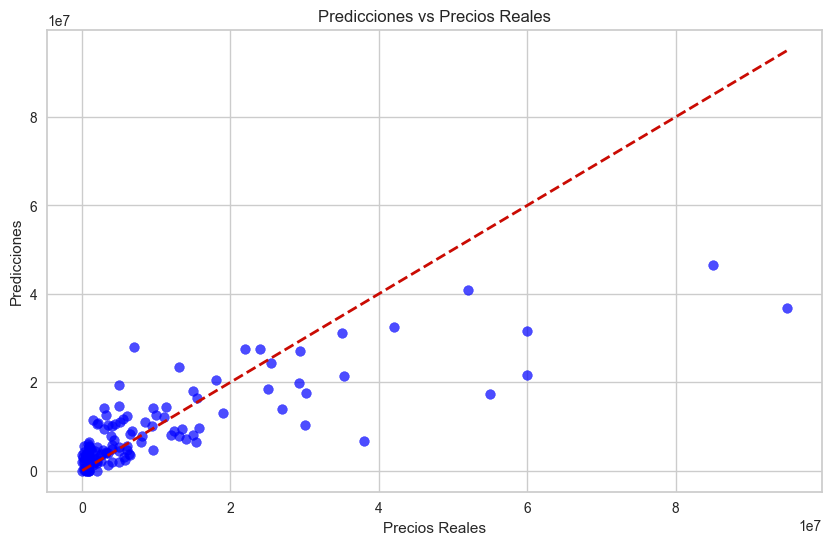

In [245]:
import matplotlib.pyplot as plt

if len(y_pred) > len(y_test):
    y_pred = y_pred[:len(y_test)]


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Predicciones vs Precios Reales")
plt.xlabel("Precios Reales")
plt.ylabel("Predicciones")
plt.grid(True)
plt.show()

¿Qué features fueron las más relevantes para predecir el precio de los jugadores?

                         Feature  Coefficient  Abs_Coefficient
14             playingtime_xG+/-    12.415697        12.415697
42  misc_Comp_eng Premier League    12.379109        12.379109
0                       misc_Age     9.630530         9.630530
29            pca_playingtime_MP     4.593153         4.593153
33                pca_stats_G-PK     3.717458         3.717458
31           pca_possession_PrgC     3.694785         3.694785
10                  passing_Cmp%     3.621850         3.621850
12               playingtime_PPM     3.443009         3.443009
4                       misc_Fld     3.221189         3.221189
38  misc_Comp_Belgian Pro League     2.976081         2.976081


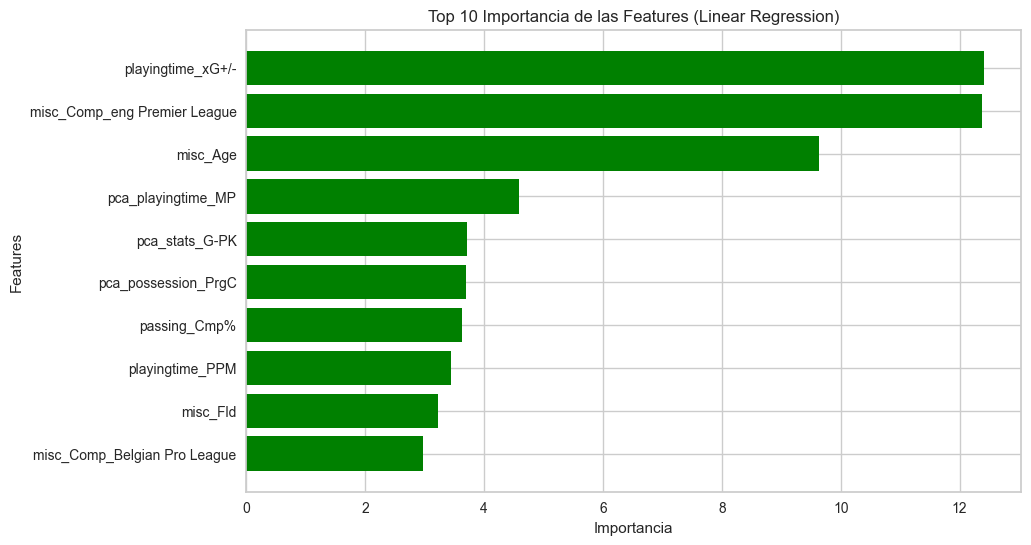

In [246]:


import pandas as pd
import matplotlib.pyplot as plt

# Extraer el modelo de regresión y los coeficientes
coeficientes = best_model.get_feature_importance()

# Crear un DataFrame con las características y sus coeficientes
features = X_train.columns
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coeficientes
})

# Calcular el valor absoluto de los coeficientes y ordenar
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Seleccionar solo el top 10
top_10_features = feature_importance.head(10)

# Imprimir el top 10
print(top_10_features)

# Crear el gráfico de barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Abs_Coefficient'], color='green')
plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más importante esté arriba
plt.title('Top 10 Importancia de las Features (Linear Regression)')
plt.xlabel('Importancia')
plt.ylabel('Features')
plt.show()


## Conclusión

El modelo CatBoost fue el más efectivo para predecir el valor de mercado de los jugadores, superando al resto de los modelos evaluados tanto en R² como en error absoluto medio (MAE). Aunque el R² oscila entre 0.4 y 0.6, lo cual indica una capacidad moderada de explicación, esto se debe en gran parte al tamaño reducido del dataset (~2300 muestras) y a la alta varianza de los valores de transferencia.

En cuanto a la importancia de las variables, el modelo identificó como factores más determinantes:

⚽ Producción ofensiva avanzada como:

- xG diferencial (playingtime_xG+/-)

🔝 La liga en la que juega el futbolista, destacándose la Premier League inglesa, conocida por sus altas cotizaciones.

🧠 Edad: los jugadores más jóvenes tienden a tener mayor valor de mercado por su proyección.

Esto demuestra que el modelo no solo toma en cuenta atributos básicos, sino también medidas complejas de rendimiento que resumen información relevante del juego.